<a href="https://colab.research.google.com/github/AtSourav/AE-n-VAE-with-CB-loss-on-stl10/blob/main/AE_stl10_CBloss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

In [75]:
img_ht = 48
img_wd = 48

input_size = (img_ht,img_wd,3)
latent_dim = 512
batch_size = 512

initializer = initializers.GlorotNormal()

In [3]:
ds = tfds.load('stl10', split='test')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/1.0.0.incomplete37SIJ4/stl10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/8000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/1.0.0.incomplete37SIJ4/stl10-test.tfrecord*...:   0%|          | 0/8…

Generating unlabelled examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/1.0.0.incomplete37SIJ4/stl10-unlabelled.tfrecord*...:   0%|         …

Dataset stl10 downloaded and prepared to /root/tensorflow_datasets/stl10/1.0.0. Subsequent calls will reuse this data.


In [4]:
ds2 = tfds.load('stl10', split='train')

In [5]:
ds3 = tfds.load('stl10', split='unlabelled[:2%]')

In [6]:
ds_to_np = list(ds.as_numpy_iterator())+list(ds2.as_numpy_iterator()) +list(ds3.as_numpy_iterator())

In [7]:
print(set(tuple(x.keys()) for x in ds_to_np))                # we converted the list of keys into a tuple since we wanted to use set() for duplicate removal
                                                             # set() only works on hashable objects like strings, numbers, and tuples,
                                                             # and not on mutables like dicts and strings

print(set(x['label'] for x in ds_to_np))
print(set(type(x['image']) for x in ds_to_np))
print(set(x['image'].shape for x in ds_to_np))
print(len(ds_to_np))

{('image', 'label')}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}
{<class 'numpy.ndarray'>}
{(96, 96, 3)}
15000


ds_to_np is a list of dictionaries where the key:value pairs are the 'image':img_ndarray, 'label'=-1. We want to collect all these arrays and form a tensor/array. There are 100k images. We'll use 50k of them in the training set, 25k for validation, and 25k for the test set.

In [8]:
random.seed(100)
random.shuffle(ds_to_np)                                    # random permutation in place
img_train = np.array([x['image'] for x in ds_to_np[:12000]])
img_valid = np.array([x['image'] for x in ds_to_np[12000:13000]])
#img_test = np.array([x['image'] for x in ds_to_np[13000:]])

img_train = img_train/255
img_valid = img_valid/255
#img_test = img_test/255

In [9]:
print(img_train.shape)

(12000, 96, 96, 3)


In [10]:
img_train = layers.Resizing(img_ht, img_wd, interpolation="bilinear")(img_train)
print(img_train.shape)

img_valid = layers.Resizing(img_ht, img_wd, interpolation="bilinear")(img_valid)
print(img_valid.shape)

#img_test = layers.Resizing(img_ht, img_wd, interpolation="bilinear")(img_test)
#print(img_valid.shape)

(12000, 48, 48, 3)
(1000, 48, 48, 3)


In [76]:
encoder_input = keras.Input(shape=input_size)

x = layers.Conv2D(8, 2, padding="valid", kernel_initializer=initializer)(encoder_input)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(16, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(32, 2, padding="same", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(64, 2, padding="same", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
#x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
#x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
#x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

#x = layers.Conv2D(512, 2, padding="valid")(x)
#x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(1024, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Flatten()(x)

#x = layers.Dense(2*latent_dim)(x)
#x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 47, 47, 8)         104       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 8)         0         
 D)                                                              
                                                                 
 re_lu (ReLU)                (None, 23, 23, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 16)        528       
                                                                 
 re_lu_1 (ReLU)              (None, 22, 22, 16)        0         
                                                           

In [77]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(1*1*2048)(latent_input)
x = layers.ReLU()(x)
x = layers.Reshape((1,1,2048))(x)

#x = layers.Dense(1*1*512)(x)
#x = layers.ReLU()(x)

x = layers.Conv2DTranspose(1024, 2, strides=1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 2, strides=1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

#x = layers.Conv2DTranspose(512, 2, strides=1, padding='valid')(x)
#x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 2, strides=1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, strides=1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, strides=1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, strides=1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, strides=1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, strides=1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, strides=1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, strides=1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, strides=1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 2, strides=1, padding='same', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 2, strides=2, padding='same', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 2, strides=2, padding='same', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(32, 2, strides=1, padding='same', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(16, 2, strides=1, padding='same', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

#x = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(x)
#x = layers.ReLU()(x)

#x = layers.Conv2DTranspose(16, 2, strides=2, padding='same')(x)
#x = layers.ReLU()(x)

#x = layers.Conv2DTranspose(32, 2, strides=1, padding='same')(x)
#x = layers.ReLU()(x)

#x = layers.Conv2DTranspose(8, 2, strides=1, padding='same')(x)
#x = layers.ReLU()(x)

x = layers.Conv2DTranspose(8, 2, strides=1, padding='same', kernel_initializer=initializer)(x)
#x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

decoder_output = layers.Conv2DTranspose(3, 2, activation='sigmoid', strides=1, padding='same', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 2048)              1050624   
                                                                 
 re_lu_15 (ReLU)             (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 2048)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 2, 2, 1024)        8389632   
 anspose)                                                        
                                                                 
 re_lu_16 (ReLU)             (None, 2, 2, 1024)        0         
                                                           

In [79]:
decoder_out = decoder(encoder(encoder_input))
VAE = keras.Model(encoder_input, decoder_out, name='VAE')

VAE.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 encoder (Functional)        (None, 512)               5290584   
                                                                 
 decoder (Functional)        (None, 48, 48, 3)         14303579  
                                                                 
Total params: 19594163 (74.75 MB)
Trainable params: 19594163 (74.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
K.clear_session()

In [80]:
l_cutoff = 0.495
u_cutoff = 0.505

def norm_CB(z):

    gate = math.logical_and(math.greater(z,l_cutoff), math.greater(u_cutoff,z))

    #z = tf.clip_by_value(z, clip_value_min = K.epsilon(), clip_value_max = 1 - K.epsilon())
    z_reg = tf.where(gate, l_cutoff, z)

    norm_reg = (2*math.atanh(1 - 2*z_reg))/(1 - 2*z_reg)
    norm_taylor = 2.0 + (8.0/3.0)*math.pow(z-0.5,2) + (32.0/5.0)*math.pow(z-0.5,4)  +  (128.0/7.0)*math.pow(z-0.5,6)


    norm = tf.where(gate, norm_taylor, norm_reg)

    return norm

def CB_logloss(true, pred):
  true = layers.Flatten()(true)
  pred = layers.Flatten()(pred)
  bce = losses.binary_crossentropy(true,pred)

  corrected_loss_tensor = bce + tf.reduce_mean(math.log(norm_CB(pred)), axis=-1 )


  return tf.reduce_mean(corrected_loss_tensor)



In [82]:
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100, decay_rate=0.98)
optim = keras.optimizers.Adam(learning_rate = 0.001)                  # clipnorm=2.0
VAE.compile(optimizer=optim,loss=CB_logloss)

In [83]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=50, steps_per_epoch=None)

Epoch 1/50
24/24 [==============================] - 18s 328ms/step - loss: 1.3850 - val_loss: 1.3826
Epoch 2/50
24/24 [==============================] - 7s 309ms/step - loss: 1.3812 - val_loss: 1.3793
Epoch 3/50
24/24 [==============================] - 7s 307ms/step - loss: 1.3793 - val_loss: 1.3787
Epoch 4/50
24/24 [==============================] - 7s 310ms/step - loss: 1.3789 - val_loss: 1.3787
Epoch 5/50
24/24 [==============================] - 8s 317ms/step - loss: 1.3787 - val_loss: 1.3784
Epoch 6/50
24/24 [==============================] - 8s 319ms/step - loss: 1.3786 - val_loss: 1.3785
Epoch 7/50
24/24 [==============================] - 8s 319ms/step - loss: 1.3786 - val_loss: 1.3783
Epoch 8/50
24/24 [==============================] - 8s 318ms/step - loss: 1.3785 - val_loss: 1.3783
Epoch 9/50
24/24 [==============================] - 8s 315ms/step - loss: 1.3792 - val_loss: 1.3786
Epoch 10/50
24/24 [==============================] - 8s 314ms/step - loss: 1.3786 - val_loss: 1.378

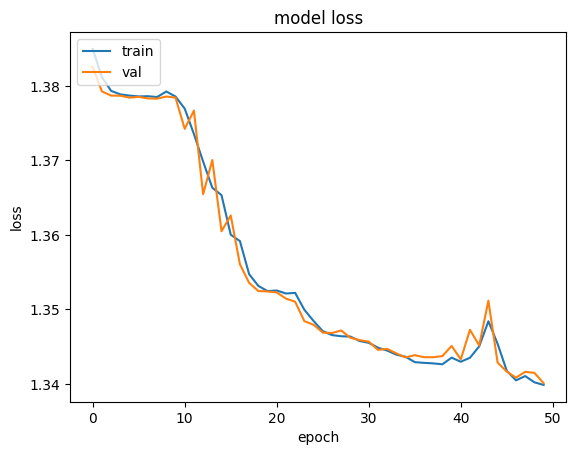

In [84]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [85]:
optim = keras.optimizers.Adam(learning_rate = 0.00085)                  # clipnorm=2.0
VAE.compile(optimizer=optim,loss=CB_logloss)
history2 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=50, steps_per_epoch=None)

Epoch 1/50
24/24 [==============================] - 19s 354ms/step - loss: 1.3462 - val_loss: 1.3433
Epoch 2/50
24/24 [==============================] - 8s 318ms/step - loss: 1.3424 - val_loss: 1.3423
Epoch 3/50
24/24 [==============================] - 8s 321ms/step - loss: 1.3406 - val_loss: 1.3404
Epoch 4/50
24/24 [==============================] - 8s 322ms/step - loss: 1.3392 - val_loss: 1.3398
Epoch 5/50
24/24 [==============================] - 8s 324ms/step - loss: 1.3385 - val_loss: 1.3389
Epoch 6/50
24/24 [==============================] - 8s 323ms/step - loss: 1.3377 - val_loss: 1.3387
Epoch 7/50
24/24 [==============================] - 8s 318ms/step - loss: 1.3377 - val_loss: 1.3384
Epoch 8/50
24/24 [==============================] - 8s 319ms/step - loss: 1.3372 - val_loss: 1.3380
Epoch 9/50
24/24 [==============================] - 8s 314ms/step - loss: 1.3373 - val_loss: 1.3380
Epoch 10/50
24/24 [==============================] - 8s 315ms/step - loss: 1.3369 - val_loss: 1.337

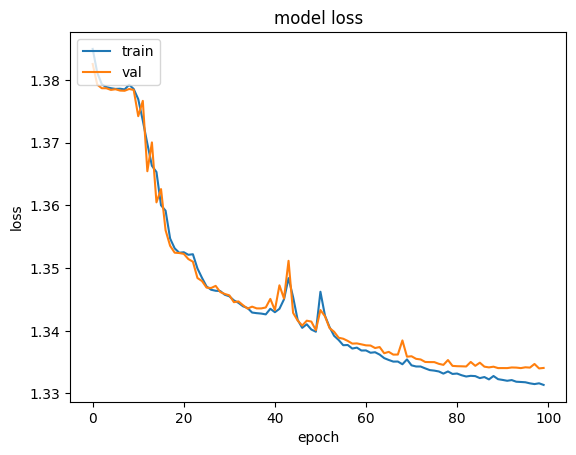

In [86]:
plt.plot(history.history['loss']+history2.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
optim = keras.optimizers.Adam(learning_rate = 0.0007)                  # clipnorm=2.0
VAE.compile(optimizer=optim,loss=CB_logloss)
history3 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=30, steps_per_epoch=None)

Epoch 1/30
20/20 [==============================] - 9s 181ms/step - loss: 1.3231 - val_loss: 1.3285
Epoch 2/30
20/20 [==============================] - 3s 145ms/step - loss: 1.3176 - val_loss: 1.3287
Epoch 3/30
20/20 [==============================] - 3s 143ms/step - loss: 1.3161 - val_loss: 1.3276
Epoch 4/30
20/20 [==============================] - 3s 144ms/step - loss: 1.3156 - val_loss: 1.3272
Epoch 5/30
20/20 [==============================] - 3s 144ms/step - loss: 1.3154 - val_loss: 1.3277
Epoch 6/30
20/20 [==============================] - 3s 147ms/step - loss: 1.3153 - val_loss: 1.3282
Epoch 7/30
20/20 [==============================] - 3s 156ms/step - loss: 1.3152 - val_loss: 1.3282
Epoch 8/30
20/20 [==============================] - 3s 145ms/step - loss: 1.3151 - val_loss: 1.3281
Epoch 9/30
20/20 [==============================] - 3s 146ms/step - loss: 1.3150 - val_loss: 1.3280
Epoch 10/30
20/20 [==============================] - 3s 154ms/step - loss: 1.3150 - val_loss: 1.3284

In [18]:
optim = keras.optimizers.Adam(learning_rate = 0.001)                  # clipnorm=2.0
VAE.compile(optimizer=optim,loss=CB_logloss)
history4 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
20/20 [==============================] - 10s 164ms/step - loss: 1.3304 - val_loss: 1.3295
Epoch 2/10
20/20 [==============================] - 3s 142ms/step - loss: 1.3208 - val_loss: 1.3284
Epoch 3/10
20/20 [==============================] - 3s 144ms/step - loss: 1.3169 - val_loss: 1.3284
Epoch 4/10
20/20 [==============================] - 3s 150ms/step - loss: 1.3150 - val_loss: 1.3288
Epoch 5/10
20/20 [==============================] - 3s 144ms/step - loss: 1.3142 - val_loss: 1.3285
Epoch 6/10
20/20 [==============================] - 3s 144ms/step - loss: 1.3138 - val_loss: 1.3288
Epoch 7/10
20/20 [==============================] - 3s 145ms/step - loss: 1.3136 - val_loss: 1.3295
Epoch 8/10
20/20 [==============================] - 3s 148ms/step - loss: 1.3136 - val_loss: 1.3298
Epoch 9/10
20/20 [==============================] - 3s 149ms/step - loss: 1.3135 - val_loss: 1.3293
Epoch 10/10
20/20 [==============================] - 3s 145ms/step - loss: 1.3135 - val_loss: 1.328

In [19]:
optim = keras.optimizers.Adam(learning_rate = 0.0005)                  # clipnorm=2.0
VAE.compile(optimizer=optim,loss=CB_logloss)
history5 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=30, steps_per_epoch=None)

Epoch 1/30
20/20 [==============================] - 9s 188ms/step - loss: 1.3173 - val_loss: 1.3285
Epoch 2/30
20/20 [==============================] - 3s 143ms/step - loss: 1.3137 - val_loss: 1.3291
Epoch 3/30
20/20 [==============================] - 3s 142ms/step - loss: 1.3129 - val_loss: 1.3289
Epoch 4/30
20/20 [==============================] - 3s 142ms/step - loss: 1.3126 - val_loss: 1.3289
Epoch 5/30
20/20 [==============================] - 3s 146ms/step - loss: 1.3125 - val_loss: 1.3292
Epoch 6/30
20/20 [==============================] - 3s 148ms/step - loss: 1.3124 - val_loss: 1.3292
Epoch 7/30
20/20 [==============================] - 3s 145ms/step - loss: 1.3124 - val_loss: 1.3292
Epoch 8/30
20/20 [==============================] - 3s 146ms/step - loss: 1.3124 - val_loss: 1.3298
Epoch 9/30
20/20 [==============================] - 3s 146ms/step - loss: 1.3124 - val_loss: 1.3293
Epoch 10/30
20/20 [==============================] - 3s 150ms/step - loss: 1.3124 - val_loss: 1.3300

In [20]:
plt.plot(history.history['loss']+history2.history['loss']+history3.history['loss']+history4.history['loss']+history5.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss']+history3.history['val_loss']+history4.history['val_loss']+history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: ignored

In [22]:
def plot_reconstruction(set, name,seed_val, epochs):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(18,8))    # it's weird that the order of axes in figsize is the opposite to that in add_subplot
  recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, latent_dim = 512', fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((64,64,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

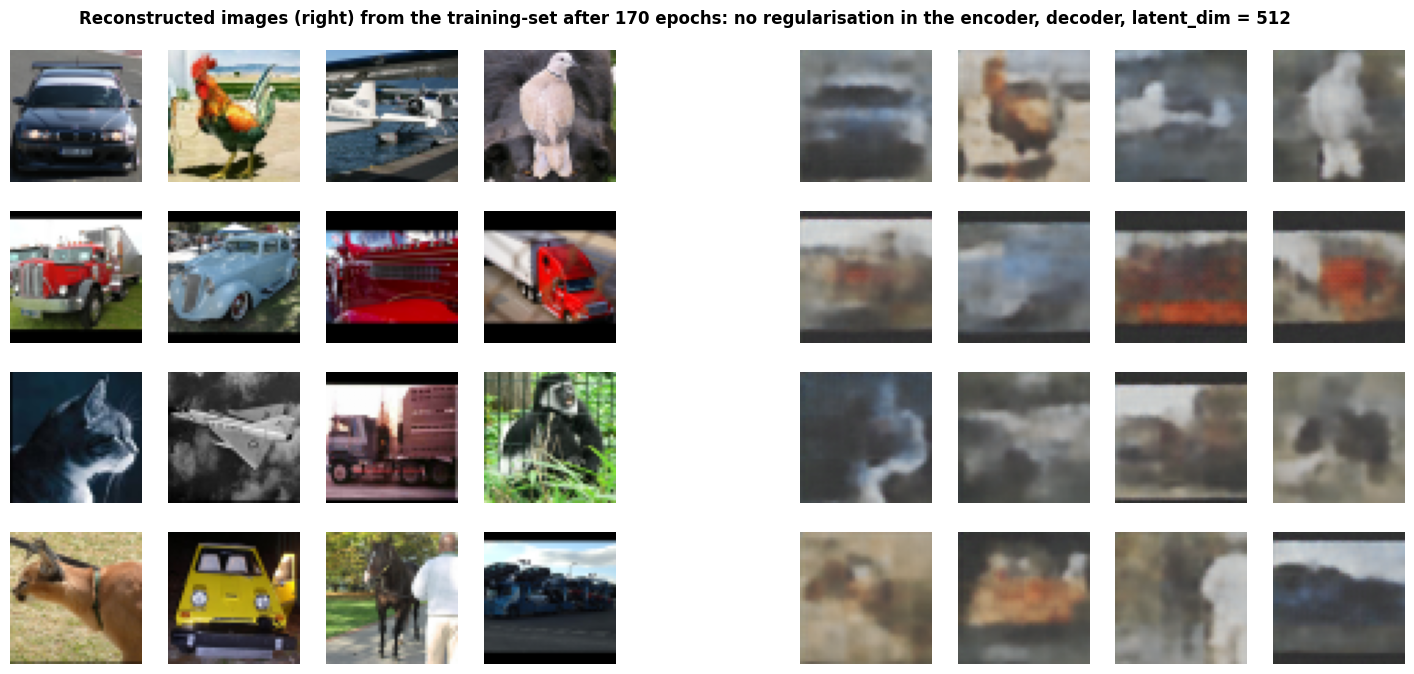

In [23]:
plot_reconstruction(img_train, 'training', 100, 170)